# Otimização de carteiras: Bala de Markowitz e CAPM

Implementação dos métodos Bala de Markowitz e CAPM. Usarei como referência meu texto sobre este assunto no meu blog Mia Math (https://www.miamath.com.br/post/modelo-de-markowitz-e-capm-como-otimizar-carteiras-de-investimento)

# Bala de Markowitz

Vamos começar com a formulação da bala de Markowitz.

* Problema 1 (sintético): Vamos considerar 3 ativos sintéticos e plotar a Bala de Markowitz

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Sorteio dos pesos:

In [169]:
def pesos_carteira(n):
    p = np.random.rand(n)
    return p/sum(p)

### Sorteio Ativos e Cálculo dos Riscos

In [170]:
# Retornos aleatorios: N ativos em M periodos
def ativos_aleatorios(n, m):
    
    retornos = np.random.randn(n,m)
    std_ativos = []
    for i in range(n):
        s = np.std(retornos[i])
        std_ativos.append(s)
    
    Var = np.array(std_ativos)**2
    
    return retornos, Var

In [171]:
ativos, Var = ativos_aleatorios(3,100)

## Parte 1: Markowitz 

### Retorno para cada ativo:

Dada uma sequencia de retornos para um dado ativo, temos que o $\texttt{valor esperado dos retornos}$ em 100 períodos é dado por:
$$ E[R_i] = \frac{1}{100 - 1} \sum_{k=1} R_{ik}
$$

In [172]:
#Valor esperado dos retornos:
def valor_esperado_retornos(ativos):
    E_R = []
    for acao in ativos:
        esp = sum(acao)/(len(acao))
        E_R.append(esp)
    return np.array(E_R)


In [173]:
E_R = valor_esperado_retornos(ativos)
E_R

array([ 0.02717107,  0.11714358, -0.03443994])

### Valor esperado carteira:

$\texttt{Valor esperado para a carteria:}$

$$ E[X] = \sum \pi_i E[R_i]
$$

In [174]:
# Valor esperado carteira:
pesos = pesos_carteira(3)

E_X = E_R.dot(pesos) #Produto escalar

E_X

0.07434217196926642

### Risco Retorno:

In [175]:
def risco_retorno(ativos):
    #Sorteio pesos:
    pesos = pesos_carteira(ativos.shape[0])
    
    #Retorno da carteira:
    E_R = valor_esperado_retornos(ativos)
    E_X = E_R.dot(pesos)
    
    #Covariancia
    Cov = np.cov(ativos)
    
    #Risco da carteira:
    w = np.asmatrix(pesos)
    cov = np.asmatrix(Cov)
    Var_X = float(w*cov*w.T)
    
    if np.sqrt(Var_X) > 2:
        return risco_retorno(ativos)
    
    return Var_X, E_X

### Gráfico Bala de Markowitz

#### Ativos Teste (3 ativos)

In [176]:
#Numero de portfolios:
N_portfolios = 50000

# Simulações:
risco = []
retornos = []
for i in range(N_portfolios):
    Variance, retorno = risco_retorno(ativos)
    risco.append(Variance)
    retornos.append(retorno)

Text(0.5, 1.0, 'Markowitz para 3 Ativos')

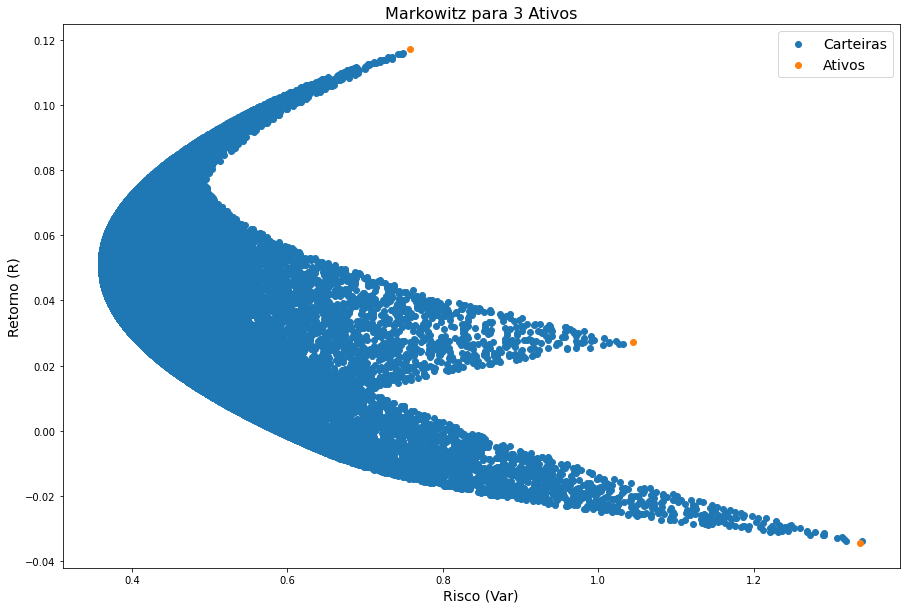

In [177]:
fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(risco ,retornos, label = 'Carteiras')
ax.scatter(Var, E_R, label = 'Ativos')
ax.set_xlabel('Risco (Var)', fontsize = 14)
ax.set_ylabel('Retorno (R)', fontsize = 14)
plt.legend(fontsize = 14)
plt.title("Markowitz para 3 Ativos", fontsize = 16)

# CAPM
Aplicar o modelo CAPM numa cesta com 4 ações do mercado brasileiro. Isto é, obtenha o histórico de 4 ações de setores diversos. Determine os retornos médios e a matriz de covariância. Usando como referência a SELIC atual como retorno do ativo livre de risco, determine a carteira ótima do Modelo CAPM. Marque num gráco risco-retorno o ponto ótimo e pontos da bala de Markowitz.

$\texttt{Taxa SELIC: }$ 6.25%

#### Índice de Sharpe:

Dados n ativos com risco e a carteira $X_Π$ formada com eles, considere a reta s que passa pelos pontos $(StDev[X_Π], E[X_Π])$ e $(0, r_0)$, onde $r_0$ é o retorno do ativo de renda fixa (ou seja, taxa de retorno livre de risco). Então o $índice$ $de$ $Sharpe$ da carteira $X_Π$ é o coeciente angular da reta s.

Será útil para buscarmos o maior retorno com menor risco (menor volatilidade). O investidor necessita de uma medida ajustada de risco e retorno, uma ferramenta que lhe permita comparar diferentes ativos, pois está interessado em investir naqueles que irão fornecer um maior retorno para um determinado montante de risco.

Dessa forma, o índice de Sharpe é uma ótima maneira de fazer uma comparação adequada entre ações e portfólios e decidir qual é melhor em termos de risco e retorno. Ademais, permite compreender se a performance de uma determinada de carteira é satisfatória quando levamos em conta o risco ajustado, ou seja, podemos escolher uma com alto retorno, mas que oferece um risco elevado.

#### Definindo variáveis importantes e importando bibliotecas:

In [1]:
#!pip install yfinance

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize as so
import yfinance as yf

precision = 50

# taxa livre de risco
rf = 6.25/100

# ativos
portfolio = [
    'JBSS3.SA',
    'PETR3.SA',
    'RENT3.SA',
    'SUZB3.SA'
]

#### Pegando preços do Yahoo Finance, formatando o dataframe e calculando os retornos

In [3]:
prices = yf.download(portfolio, period = '5y')
prices = prices['Adj Close']

pct_change = prices.pct_change(fill_method='ffill')

if len(portfolio) == 1:
    pct_change = pct_change.to_frame()

pct_change.columns = portfolio

pct_change = pct_change.dropna(how='all').iloc[-252:, :] # último ano apenas

print(pct_change.head())

[*********************100%***********************]  4 of 4 completed
            JBSS3.SA  PETR3.SA  RENT3.SA  SUZB3.SA
Date                                              
2020-09-16 -0.031535  0.003658 -0.002650 -0.026795
2020-09-17 -0.002142  0.022323  0.005125  0.030265
2020-09-18 -0.000859 -0.022282 -0.004721  0.021012
2020-09-21 -0.012033 -0.030082 -0.035863 -0.030370
2020-09-22 -0.021314 -0.000470  0.018303 -0.023903


<AxesSubplot:xlabel='Date'>

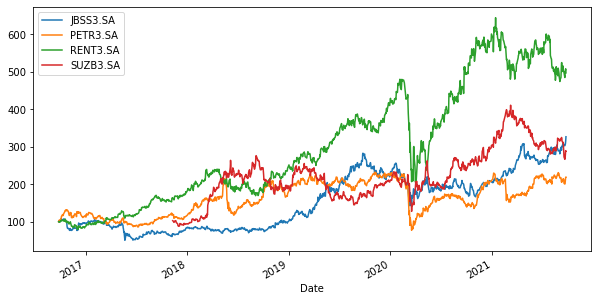

In [4]:
(prices / prices.iloc[0] * 100).plot(figsize=(10, 5))

In [5]:
prices.corr()

,JBSS3.SA,PETR3.SA,RENT3.SA,SUZB3.SA
JBSS3.SA,1.000000,0.679256,0.864737,0.521702
PETR3.SA,0.679256,1.000000,0.682748,0.314323
RENT3.SA,0.864737,0.682748,1.000000,0.707822
SUZB3.SA,0.521702,0.314323,0.707822,1.000000


Definindo funções que recebem um vetor de percentuais para calcular dados sobre o portfólio:

In [182]:
def port_std(array):
    ''' calculate standard deviation 
        of returns given an array of weights '''

    df = pct_change.copy()
    for i, pct in enumerate(array):
        df.iloc[:, i] = df.iloc[:, i] * pct
    
    df = (df.sum(axis=1)).to_frame()

    return df.std().iloc[0] 

def port_ret(array):
    ''' calculate portfolio return 
    given an array of weights '''

    df = pct_change.copy()
    for i, pct in enumerate(array):
        df.iloc[:, i] = df.iloc[:, i] * pct
    
    df = (df.sum(axis=1) + 1).cumprod()

    return df.iloc[-1] - 1

def sharpe(array, risk_free):
    ''' calculate sharpe ratio given an array 
    of weights and the risk-free rate'''
    return (port_ret(array) - risk_free) / port_std(array)


Estabelecendo variáveis importantes para a otimização

In [7]:
# gerando um portfólio aleatório para iniciar a otimização
starting_guess = np.random.rand(pct_change.shape[1])
starting_guess = starting_guess / starting_guess.sum()

# cada ativo pode ter um peso de 0 a 100%, mas a soma dos pesos deve ser igual a 100%
bounds = tuple((0, 1) for i in starting_guess)
constraints = {'type': 'eq', 'fun': lambda x: 1 - sum(x)}

Fazendo a otimização

In [184]:
# encontrando portfólios com mínimo retorno, máximo retorno e máximo sharpe possíveis
min_ret_port = so.minimize(lambda x:      port_ret(x), starting_guess, method='SLSQP', bounds=bounds, constraints=constraints).x
max_ret_port = so.minimize(lambda x: -1 * port_ret(x), starting_guess, method='SLSQP', bounds=bounds, constraints=constraints).x
max_shp_port = so.minimize(lambda x: -1*sharpe(x, rf), starting_guess, method='SLSQP', bounds=bounds, constraints=constraints).x

# pegando um range de retornos esperados possíveis (apenas positivos) entre o máximo e mínimo retornos encontrados
return_range = np.linspace(max(port_ret(min_ret_port), 0), port_ret(max_ret_port), precision)

# iniciando um dataframe com uma coluna com os retornos e outra de zeros que guardarão as volatilidades mínimas
return_std_df = pd.DataFrame({'exp ret': return_range, 'std': np.full(len(return_range), 0)})

# para cada retorno esperado, buscar o menor desvio padrão possível
for i, row in return_std_df.iterrows():
    constraints_row = ({'type': 'eq', 'fun': lambda x: 1 - sum(x)}, {'type': 'eq', 'fun': lambda x: row['exp ret'] - port_ret(x)})
    port_given_return = so.minimize(port_std, starting_guess, method='SLSQP', bounds=bounds, constraints=constraints_row).x
    
    return_std_df.iloc[i, 1] = port_std(port_given_return)
    
    if not (i + 1) % 10:
        print(f'{i+1} / {len(return_std_df)}')

print('optimization ready:')
print(return_std_df.head())

10 / 50
20 / 50
30 / 50
40 / 50
50 / 50
optimization ready:
    exp ret       std
0  0.081318  0.025239
1  0.090990  0.024046
2  0.100662  0.022828
3  0.110334  0.021589
4  0.120006  0.020339


#### Calculando a CML

#### Modelo CAPM:

A equação que descreve a reta para um ponto $(StDev[X_Π], E[X_Π])$ presente na $Bala$ $de$ $Markowitz$ com juros dado por $r_0$ é:

$$ E - r_0 = \frac{E[X_Π] - r_0}{StDev[X_Π]} (\sigma)
$$


In [185]:
# calculate the capital market line
max_shp_return = port_ret(max_shp_port)*100
max_shp_std    = port_std(max_shp_port)*100

def CML(x):
    return ((max_shp_return-rf*100)/max_shp_std)*(x) + rf*100

return_std_df *= 100

Plotando os dataframes calculados

portfólio de maior índice de Sharpe
      ativo  alocação
0  JBSS3.SA     75.78
1  PETR3.SA     20.85
2  RENT3.SA      0.00
3  SUZB3.SA      3.36


 retorno esperado: 53.33%
      desvio padrão: 1.75%
   índice de Sharpe: 26.91


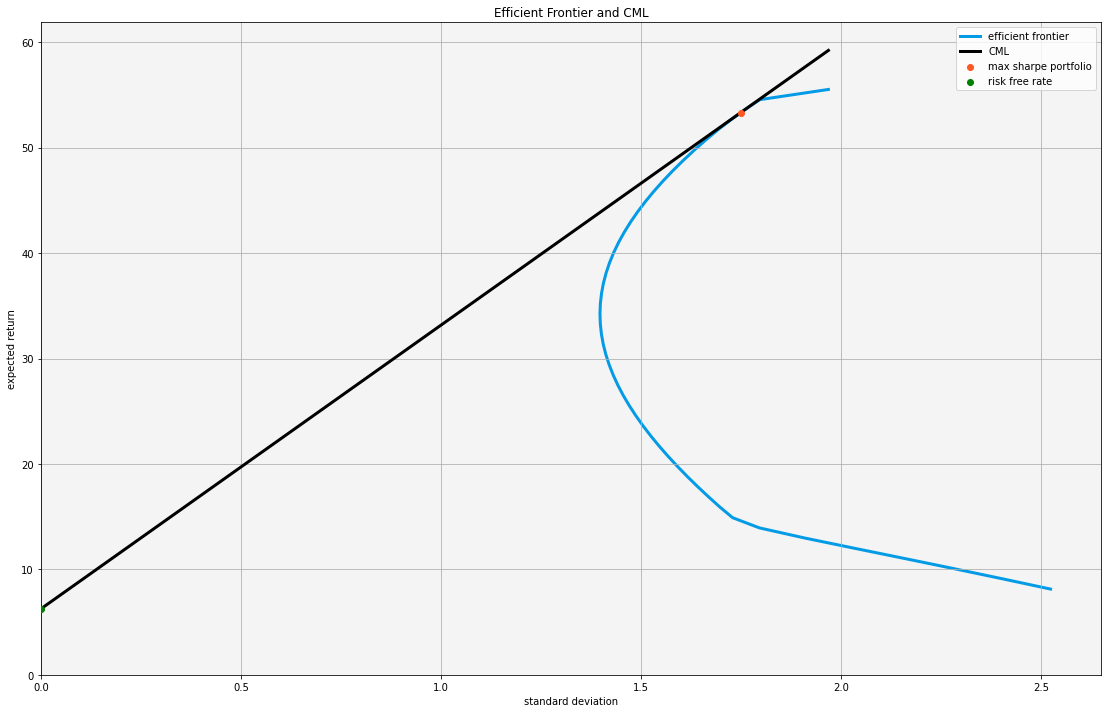

In [186]:
# plot the CML and the efficient frontier
plt.rcParams['figure.figsize'] = [19, 12]
fig = plt.figure(constrained_layout=False)
gs  = fig.add_gridspec(1, 1)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(return_std_df['std'], return_std_df['exp ret'], color='#039BE5', lw=3, zorder=0, label='efficient frontier')
ax1.scatter(port_std(max_shp_port)*100, port_ret(max_shp_port)*100, color='#FF5722', zorder=10, label='max sharpe portfolio')

x = np.linspace(0, return_std_df['std'].iloc[-1], num=2)
ax1.plot(x, CML(x), c='k', label='CML', zorder=5, lw=3)
ax1.scatter(0, rf*100, zorder=10, c='green', label='risk free rate')

ax1.set_title('Efficient Frontier and CML')
ax1.set_xlabel('standard deviation')
ax1.set_ylabel('expected return')
ax1.set_facecolor('#F4F4F4')
ax1.grid()
plt.legend()
plt.xlim(xmin=0)
plt.ylim(ymin=0)

print('portfólio de maior índice de Sharpe')
print(pd.DataFrame({'ativo': portfolio, 'alocação': [round(x*100, 2) for x in max_shp_port]}))
print(f'''
\n retorno esperado: {round(port_ret(max_shp_port)*100, 2)}%
      desvio padrão: {round(port_std(max_shp_port)*100, 2)}%
   índice de Sharpe: {round(sharpe(max_shp_port, rf), 2)}''')


